In [14]:
import pandas as p

team_stats = pd.read_excel("C:/Users/carte/OneDrive/Documents/Large_ControlStatsBook.xlsx")

#This time, we have a MUCH larger sample size. Let's see if this makes a difference.
#Let's see how many rows we have.
team_stats.shape[0]

2158

In [15]:
#Like last time, let's add our new columns for win%

team_stats['Lineup Win %'] = (team_stats['Lineup Wins'] / ((team_stats['Lineup Losses']) + team_stats['Lineup Wins'])).round(4)

team_stats['Match Win %'] = (team_stats['Match Wins']*2 + team_stats['Match Draws']) / ((team_stats['Match Losses'] + team_stats['Match Wins'] + team_stats['Match Draws'])*2).round(3)

team_stats.head(3)

,Team,Season,Power,Attack Damage,Attack Speed,Critical %,Critical X,Health,Spawn Time,Lineup Wins,Lineup Losses,Match Wins,Match Losses,Match Draws,Lineup Win %,Match Win %
0,Universal_Swashbucklers,0,52.69,48.08,12.08,0.03597,9.416,533.775,12.86,217,583,4,82,14,0.2712,0.11
1,Universal_Halflings,0,53.83,45.89,12.08,0.03383,10.329,538.554,12.28,278,522,13,63,24,0.3475,0.25
2,Universal_Giants,0,52.78,52.47,12.08,0.03758,9.806,545.806,12.94,307,493,18,66,16,0.3838,0.26


Rather than just doing the same thing again, but with a larger sample size, I am trying two new things this time.
First, while maintaining my focus on feature importance (particularly Power and Attack Speed) I'm going to create another multi-output Random Forest model, this time examining each feature's importance to Lineup Win % and Match Win %, since the latter is ultimately what determines success in the playoffs.

Second, I'm going to visualize the data to see if the eye test matches with the trends explained by the model.

In [33]:
#Import modules necessary to create the models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler

In [34]:
team_stats_copy = team_stats.copy()

features = team_stats_copy.drop(columns=['Team', 'Season', 'Lineup Wins', 'Lineup Losses',
                                         'Match Wins', 'Match Losses', 'Match Draws',
                                         'Lineup Win %', 'Match Win %'])

# Target now contains both Lineup Win % and Match Win %
target = team_stats[['Lineup Win %', 'Match Win %']]

#Let's also try a different scaler
scaler = RobustScaler()
features_scaled = scaler.fit_transform(features)
features_scaled = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)

features_train, features_test, target_train, target_test = train_test_split(features_scaled, target,
                                                                            test_size=0.18, random_state=49)

In [35]:
#Create and fit the model! This time, let's use a lot more estimators to ensure accuracy.
model = RandomForestRegressor(n_estimators=1000, random_state=49)
model.fit(features_train, target_train)

RandomForestRegressor(n_estimators=1000, random_state=49)

In [36]:
feature_importances = model.feature_importances_
for name, importance in zip(features_scaled.columns, feature_importances):
    print(f"{name}: {importance}")

Power: 0.09266596651230455
Attack Damage: 0.17027456571048905
Attack Speed: 0.19671238118923268
Critical %: 0.18645273395113043
Critical X: 0.118915948825729
Health: 0.15608456803289367
Spawn Time: 0.07889383577822079


This seems odd. From my experience playing the game on my own time, Power is an incredibly important statistic, and teams with the highest power are often the most successful. At the same time, I've always thought of Critical % as having relatively little effect on the game, whereas the model says it's twice as valuable.

Perhaps I'm looking at this wrong. Let's chart the data and see what we find.

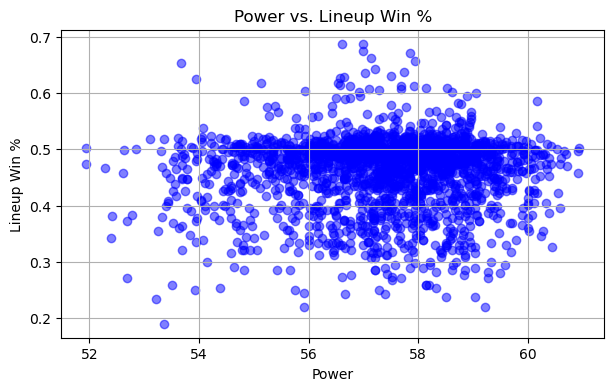

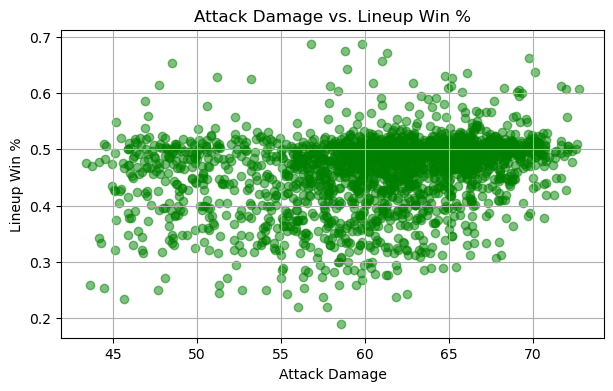

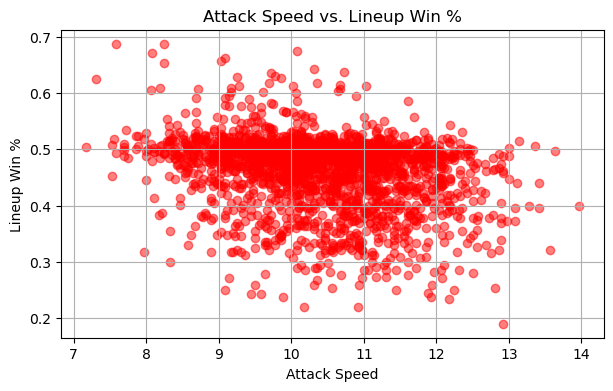

In [52]:
import matplotlib.pyplot as plt

def plot_against_wins(variable, color, lineup='Lineup'):
    plt.figure(figsize=(7, 4))
    if lineup:
        plt.scatter(team_stats[variable], team_stats[f'{lineup} Win %'], color=color, alpha=0.5)
        plt.ylabel(f'{lineup} Win %')
    else:
        plt.scatter(team_stats[variable], team_stats[f'{lineup} Win %'], color=color, alpha=0.5)
        plt.ylabel(f'{lineup} Win %')
    plt.xlabel(variable)
        
    plt.title(f'{variable} vs. {lineup} Win %')
    plt.grid(True)
    plt.show()
    
variables = ['Power', 'Attack Damage', 'Attack Speed', 'Critical %', 'Critical X', 'Health', 'Spawn Time']
colors = ['blue', 'green', 'red', 'yellow', 'blue', 'green', 'red',]

for i in range(3):
    plot_against_wins(variables[i], colors[i])

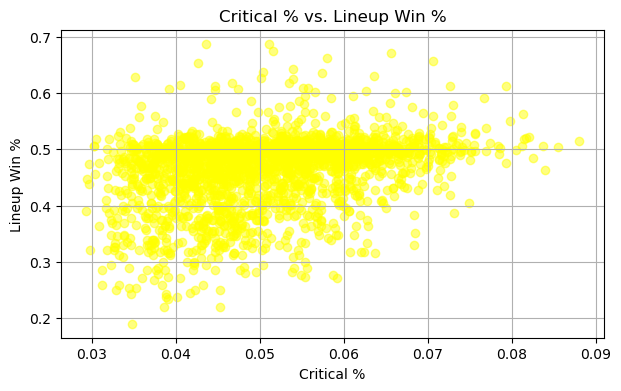

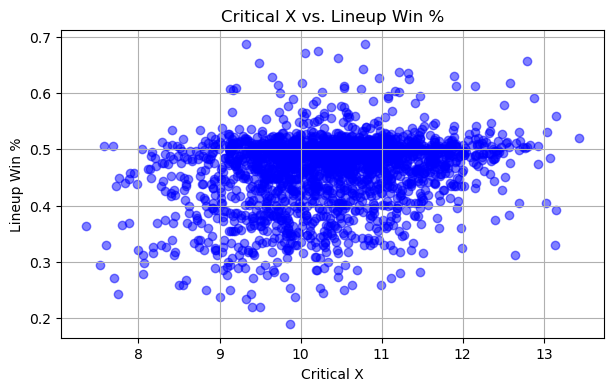

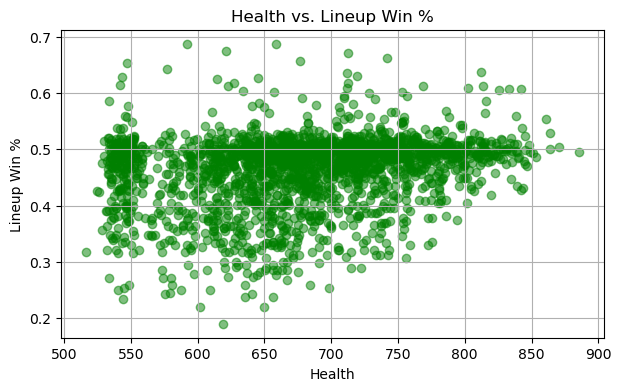

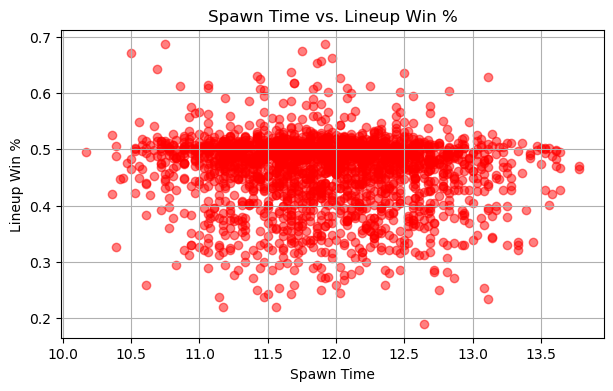

In [55]:
for i in range(3, 7):
    plot_against_wins(variables[i], colors[i])

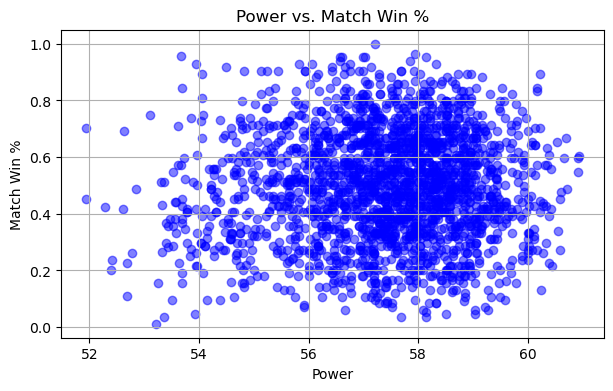

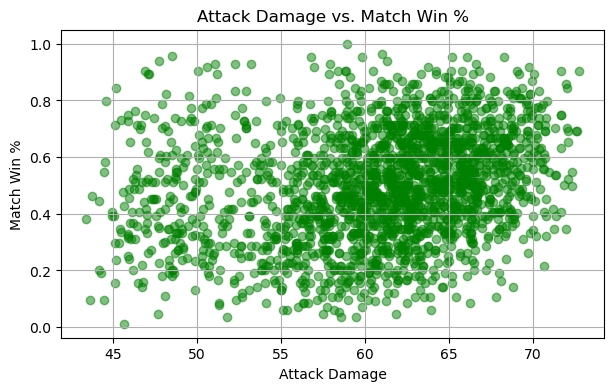

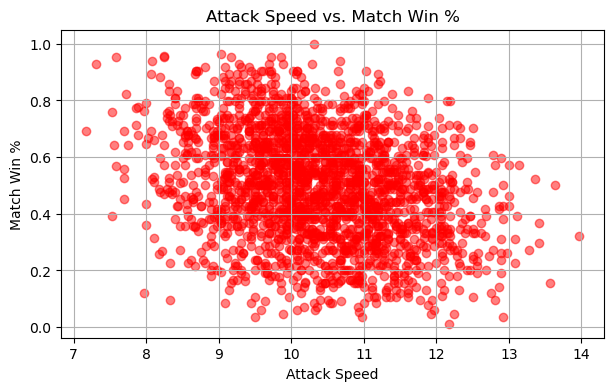

In [56]:
#Let's also look at the relationship between the targets and Match Win%. Perhaps it will be more clear.
for i in range(3):
    plot_against_wins(variables[i], colors[i], 'Match')

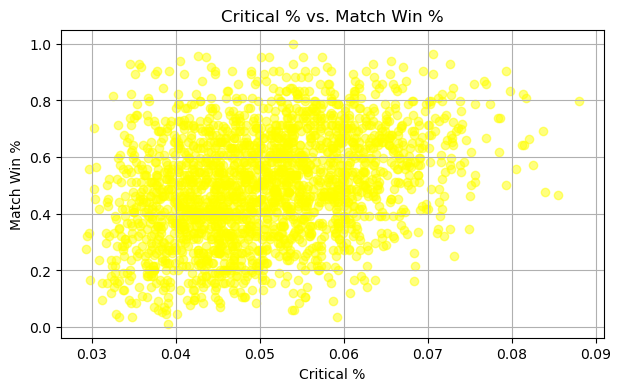

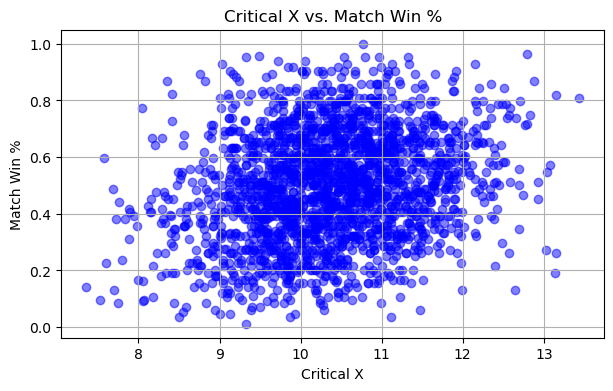

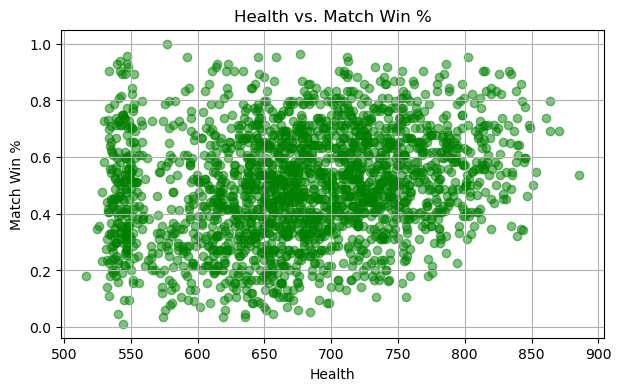

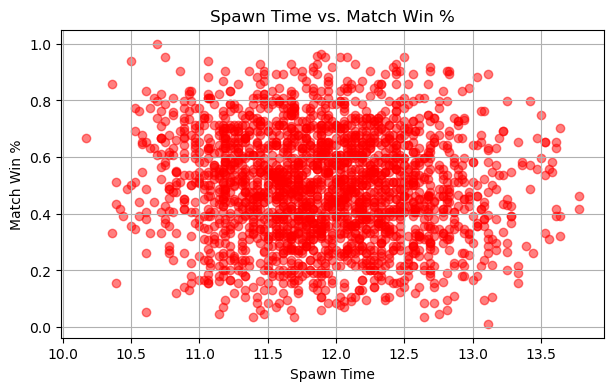

In [57]:
for i in range(3, 7):
    plot_against_wins(variables[i], colors[i], 'Match')

Plotting it against Match Win % makes it a bit more clear, but there's still a major lack of a trend especially with Power.
With this large of a sample size, I think I'm just wrong about my assumptions about Power, and I might have figured out why.
It can be seen in Player_Creator.py that players are created to be somewhat balanced. Yes, s_tiers are much better than c_tiers, but not by that much. Each of them has one trait where they exceed and one where they lack, meaning that the traits are balanced AGAINST each other. Because an increase in Critical % (at the point of player creation) also leads to a decrease in a few other statistics, its overall effect is very tough to measure. Before, I was only considering one half of the equation, which was the positive impacts of a raise in any given statistic, and not the impact that has on other statistics.

In [58]:
#One last thing I'm interested in is if the model behaves differently when the target is only Match Win %.
target = team_stats['Match Win %']

features_train, features_test, target_train, target_test = train_test_split(features_scaled, target,
                                                                            test_size=0.18, random_state=49)
new_model = RandomForestRegressor(n_estimators=500, random_state=988)
new_model.fit(features_train, target_train)


feature_importances = new_model.feature_importances_
for name, importance in zip(features_scaled.columns, feature_importances):
    print(f"{name}: {importance}")

Power: 0.09430828127344162
Attack Damage: 0.17109547708448244
Attack Speed: 0.19708379843817628
Critical %: 0.1863481268711627
Critical X: 0.11786294211490206
Health: 0.15545882660610308
Spawn Time: 0.07784254761173186


In [59]:
#Extremely close to the other model. How about Lineup Win % only?
#One last thing I'm interested in is if the model behaves differently when the target is only Match Win %.
target = team_stats['Lineup Win %']

features_train, features_test, target_train, target_test = train_test_split(features_scaled, target,
                                                                            test_size=0.18, random_state=49)
new_model2 = RandomForestRegressor(n_estimators=500, random_state=988)
new_model2.fit(features_train, target_train)


feature_importances = new_model2.feature_importances_
for name, importance in zip(features_scaled.columns, feature_importances):
    print(f"{name}: {importance}")

Power: 0.0935303618841716
Attack Damage: 0.1721210784037113
Attack Speed: 0.18734031877799057
Critical %: 0.17180103389730567
Critical X: 0.14703589605160244
Health: 0.15380144114358743
Spawn Time: 0.074369869841631


Also very close. This makes sense, of course, given that there is a direct cause and effect relationship between lineup wins and match wins. With that, this leaves only one question remaining: why is it that in our last analysis, we got the following results, radically different from this experiment?

Was it a difference in the model, or was the stark difference solely because of the differnt datasets? Let's test this by creating an identical copy of the model from the previous experiment, the only difference being that it is trained on this new data.

In [60]:
team_stats_copy2 = team_stats.copy()

target = team_stats['Lineup Win %']

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
features_scaled = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)

#Old model had test_size set to 150, which was 18.75% of that dataset. Thus, test_size is set to 0.1875 here,
features_train, features_test, target_train, target_test = train_test_split(features_scaled, target,
                                                                            test_size=0.1875, random_state=777)

new_model3 = RandomForestRegressor(n_estimators=800, random_state=777)
new_model3.fit(features_train, target_train)

feature_importances = new_model3.feature_importances_
for name, importance in zip(features_scaled.columns, feature_importances):
    print(f"{name}: {importance}")

Power: 0.09609833843062858
Attack Damage: 0.171614441820483
Attack Speed: 0.18307246078269448
Critical %: 0.1911958406864604
Critical X: 0.12975849127773695
Health: 0.15420792887210658
Spawn Time: 0.07405249812989002


This model, when trained on our new and much larger dataset, produced strikingly similar results to our other models. This is not surprising, but it leaves one burning question: why were the results so different last time? We addressed the issue of statistics counterbalancing one another, but this phenomenon was also present last simulation.

Yes, of course, the dataset was smaller, but the new one is less than 4x its size. And the base code of CONTROL did not fundamentally change. 

The answer is not the size of the dataset, but the NATURE of the dataset. Last dataset was made entirely of teams from 6 of the 8 regional leagues (in a test environment used only for the test), which are at roughly the same skill level.
This set was created from running the game normally, and a consequence is that it now contains results from 8 different regional leagues AND the Universal league, which is composed of the best of the 8 regional leagues and is on a different plane of skill entirely. Raw statistics are not helpful, since a team with 50 power might win 80% of their games in the Regional league, but 50% in the Universal League. What determines winning percentage is a team's statistics IN RELATION TO THEIR COMPETITORS.

One way around this, of course, is to do what I did last time. But there's a more interesting and more challenging solution I want to try.
In my next piece of analysis, I will calculate values in relation to competitors of the league, where 0 is the league average. From there, I will create new models, which perhaps can shine new light on the situation.